In [4]:
%matplotlib inline
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.stats.multitest import fdrcorrection

def save_df_to_npz(obj, filename):
    np.savez_compressed(filename, data=obj.values, index=obj.index.values, columns=obj.columns.values)

def load_df_from_npz(filename):
    with np.load(filename, allow_pickle=True) as f:
        obj = pd.DataFrame(**f)
    return obj

## First we do an explicit analysis of replicate samples across and within the two arrays to find variants that are frequently discrepant between the two batches

## Output subset of samples with duplicates as a VCF

In [5]:
postpostfn = 'gs://popgen-gwas/data/metadata/Annotated_GenotypedData/ExpectedDuplicates/Post2016_DuplicateSelection_Merged_Complete_20190822.tsv'
postpost = pd.read_csv(postpostfn, sep='\t')

In [6]:
prepostreps = pd.read_csv('gs://popgen-gwas/data/metadata/Annotated_GenotypedData/ExpectedDuplicates/Pre_To_Post_Duplicate_Mapping_20190822.tsv', sep='\t')
prepostreps['Post_ID'].head()

0      WG0284565-DNA_C12_G-7167
1       WG0284572-DNA_E05_S-107
2      WG0284580-DNA_H09_G-7895
3    WG0284582-DNA_A02_F-SL-71C
4    WG0284582-DNA_A03_SM-72YJL
Name: Post_ID, dtype: object

In [7]:
postrepsamples = list(set(postpost['IID']).union(prepostreps['Post_ID']))

In [8]:
a = '../../data/tmp/plink/H3/BroadPost2016_H3_B1and2_UpdateSexandID.Coord.RefAllele.NoMulti.NoSexDisc.mDupVars.renamesexchr.sorted.fixPloidy'

In [9]:
phenofn = 'gs://popgen-gwas/data/metadata/Annotated_GenotypedData/preANDpost2016_Merged_Complete_Metadata_WithAge_20210818.tsv'

In [10]:
metadata = pd.read_csv(phenofn, sep='\t')
metadata.index = metadata['Full_IID']

In [14]:

cmd = 'cp {a}.fam {a}.orig.fam'.format(a=a)
print(cmd)
!{cmd}
fam = pd.read_csv(a+'.fam', sep='\t', header=None)
fam.index = fam[1]
fam[4] = metadata.loc[fam.index, 'sex'].replace({np.nan:0, 'M':1, 'F':2})
fam.to_csv(a+'.fam', sep='\t', header=False, index=False)
fam.head()

cp ../../data/tmp/plink/H3/BroadPost2016_H3_B1and2_UpdateSexandID.Coord.RefAllele.NoMulti.NoSexDisc.mDupVars.renamesexchr.sorted.fixPloidy.fam ../../data/tmp/plink/H3/BroadPost2016_H3_B1and2_UpdateSexandID.Coord.RefAllele.NoMulti.NoSexDisc.mDupVars.renamesexchr.sorted.fixPloidy.orig.fam


,0,1,2,3,4,5
1,,,,,,
WG0284565-DNA_A03_G-5686,0,WG0284565-DNA_A03_G-5686,0,0,2,-9
WG0341167-DNA_A03_1079-LV-18,0,WG0341167-DNA_A03_1079-LV-18,0,0,1,-9
WG0284565-DNA_B02_G-5585,0,WG0284565-DNA_B02_G-5585,0,0,2,-9
WG0341167-DNA_A04_0406-LV-18,0,WG0341167-DNA_A04_0406-LV-18,0,0,1,-9
WG0284565-DNA_B03_G-4468,0,WG0284565-DNA_B03_G-4468,0,0,1,-9


In [15]:
fam[1].isin(postrepsamples).value_counts()

False    2102
True      739
Name: 1, dtype: int64

In [16]:
repsamplesfn = a+'.HasReplicateSamples.tsv'
print(repsamplesfn)
fam.loc[fam[1].isin(postrepsamples), [0,1]].to_csv(repsamplesfn, sep='\t', header=None, index=False)

../../data/tmp/plink/H3/BroadPost2016_H3_B1and2_UpdateSexandID.Coord.RefAllele.NoMulti.NoSexDisc.mDupVars.renamesexchr.sorted.fixPloidy.HasReplicateSamples.tsv


In [17]:
cmd = 'plink --bfile {a} --recode vcf-iid --out {a}.HasReplicateSamples --keep-allele-order --keep {a}.HasReplicateSamples.tsv'.format(a=a)
print(cmd)
!{cmd}

plink --bfile ../../data/tmp/plink/H3/BroadPost2016_H3_B1and2_UpdateSexandID.Coord.RefAllele.NoMulti.NoSexDisc.mDupVars.renamesexchr.sorted.fixPloidy --recode vcf-iid --out ../../data/tmp/plink/H3/BroadPost2016_H3_B1and2_UpdateSexandID.Coord.RefAllele.NoMulti.NoSexDisc.mDupVars.renamesexchr.sorted.fixPloidy.HasReplicateSamples --keep-allele-order --keep ../../data/tmp/plink/H3/BroadPost2016_H3_B1and2_UpdateSexandID.Coord.RefAllele.NoMulti.NoSexDisc.mDupVars.renamesexchr.sorted.fixPloidy.HasReplicateSamples.tsv
PLINK v1.90b4 64-bit (20 Mar 2017)             www.cog-genomics.org/plink/1.9/
(C) 2005-2017 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to ../../data/tmp/plink/H3/BroadPost2016_H3_B1and2_UpdateSexandID.Coord.RefAllele.NoMulti.NoSexDisc.mDupVars.renamesexchr.sorted.fixPloidy.HasReplicateSamples.log.
Options in effect:
  --bfile ../../data/tmp/plink/H3/BroadPost2016_H3_B1and2_UpdateSexandID.Coord.RefAllele.NoMulti.NoSexDisc.mDupVars.renamesexchr.sorted

## Evaluate batch effect between the 2 H3 batches

In [9]:
repvcffn = '../../data/tmp/plink/H3/BroadPost2016_H3_B1and2_UpdateSexandID.Coord.RefAllele.NoMulti.NoSexDisc.mDupVars.renamesexchr.sorted.fixPloidy.HasReplicateSamples.vcf'
repvcf = pd.read_csv(repvcffn, sep='\t', skiprows=30)
print('a')
repvcf.index = repvcf['ID']
repvcf = repvcf.iloc[:,9:]
print('b')
repvcf = repvcf.replace({'1/1':2, '0/0':0, '0/1':1, './.':-1})
print('c')
repvcf.head()

a
b
c


,WG0341167-DNA_A04_0406-LV-18,WG0284565-DNA_B03_G-4468,WG0284565-DNA_B12_G-7174,WG0341167-DNA_A10_0205-LV-18,WG0284565-DNA_C12_G-7167,WG0341167-DNA_A11_0221-LV-18,WG0284565-DNA_D02_G-4899,WG0284565-DNA_E12_G-7127,WG0341167-DNA_B10_0651-LV-18,WG0284565-DNA_G03_G-5527,...,WG0284587-DNA_H08_G-7823,WG0284565-DNA_A02_G-5231,WG0284565-DNA_A11_G-5135,WG0284565-DNA_F04_G-4007,WG0284565-DNA_H08_G-5932,WG0284569-DNA_F05_S-275,WG0284572-DNA_A10_S-079,WG0284579-DNA_D04_C-284-1,WG0284584-DNA_A03_C-016-1,WG0284584-DNA_G01_G-5748
ID,,,,,,,,,,,,,,,,,,,,,
1:54676:A:G,2,2,2,2,2,2,2,2,2,2,...,2,2,2,2,2,2,2,2,2,2
1:108310:A:G,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,-1,0,0,0,0
1:256586:A:C,0,0,1,0,0,0,0,0,1,0,...,0,0,1,0,0,0,0,0,1,1
1:534247:A:G,0,0,0,0,0,0,0,0,1,0,...,1,1,0,0,0,0,0,0,0,0
1:723918:A:G,0,0,1,0,0,0,1,0,1,0,...,0,0,0,1,0,0,0,0,0,0


In [10]:
outfn = '../../data/tmp/plink/H3/BroadPost2016_H3_B1and2_UpdateSexandID.Coord.RefAllele.NoMulti.NoSexDisc.mDupVars.renamesexchr.sorted.fixPloidy.HasReplicateSamples.vcf.npz'

In [11]:
save_df_to_npz(repvcf, outfn)

In [12]:
! ls ../../data/tmp/plink/H3/*.vcf

../../data/tmp/plink/H3/BroadPost2016_H3_B1and2_UpdateSexandID.Coord.RefAllele.NoMulti.NoSexDisc.mDupVars.renamesexchr.sorted.fixPloidy.HasReplicateSamples.vcf


In [13]:
! gsutil ls gs://popgen-gwas/data/analysis/Imputation_BatchCorrection/H3/*.vcf

gs://popgen-gwas/data/analysis/Imputation_BatchCorrection/H3/BroadPost2016_H3_B1and2_UpdateSexandID.Coord.TopA1.NoMulti.NoSexDisc.mDupVars.vcf


In [14]:
repvcf = load_df_from_npz(outfn)

In [12]:
b1 = '../../data/tmp/plink/H3/USA_H3Africa_Broad_Barnes_2018.11_Batch1_Final_TopStrand'
b2 = '../../data/tmp/plink/H3/Broad_Barnes_H3Africa_2019.04'

In [13]:
b1samps = list(pd.read_csv(b1+'.fam', sep=' ', header=None)[1])
b2samps = list(pd.read_csv(b2+'.fam', sep=' ', header=None)[1])
merged_dict = dict(zip(b1samps, ['B1']*len(b1samps)))
print(len(merged_dict))
merged_dict.update(dict(zip(b2samps, ['B2']*len(b2samps))))
print(len(b1samps), len(b2samps), len(merged_dict))

1598
1598 1440 3038


In [17]:
dupgroups = []
for dp in postpost['Duplicate_Pair'].unique():
    items = dp.split('---')
    b1 = []
    b2 = []
    for i in items:
        if i in repvcf.columns:
            if i in b1samps:
                b1.append(i)
            elif i in b2samps:
                b2.append(i)
    dupgroups.append([b1, b2])

In [18]:
cols = ['B1_AllRep_Concordance', 'B1_Dedup_Concordance', 'B1_AllRep_Total', 'B1_Dedup_Total',
        'B2_AllRep_Concordance', 'B2_Dedup_Concordance', 'B2_AllRep_Total', 'B2_Dedup_Total',
        'Between_AllRep_Concordance', 'Between_Dedup_Concordance', 'Between_AllRep_Total', 'Between_Dedup_Total']
results = pd.DataFrame(0, index=repvcf.index, columns=cols)
results.head()

disc = np.zeros(results.shape[0])
counter = pd.Series(disc, index=results.index)
discrepancy = pd.Series(disc, index=results.index)
for (b1, b2) in dupgroups:
    if len(b1) > 1:
        counter_new = counter.copy()
        discrepancy_new = discrepancy.copy()
        for i in range(len(b1)-1):
            for j in range(i+1, len(b1)):
                nonnull = (repvcf[b1[i]] != -1) & (repvcf[b1[j]] != -1)
                counter_new += nonnull
                discrepancy_new += ((repvcf[b1[i]] != repvcf[b1[j]]) & nonnull)
        results['B1_AllRep_Total'] += counter_new
        results['B1_AllRep_Concordance'] += discrepancy_new
        ind = counter_new > 0
        results.loc[ind, 'B1_Dedup_Concordance'] += (discrepancy_new.loc[ind] / counter_new.loc[ind])
        results.loc[ind, 'B1_Dedup_Total'] += 1
        
    if len(b2) > 1:
        counter_new = counter.copy()
        discrepancy_new = discrepancy.copy()
        for i in range(len(b2)-1):
            for j in range(i+1, len(b2)):
                nonnull = (repvcf[b2[i]] != -1) & (repvcf[b2[j]] != -1)
                counter_new += nonnull
                discrepancy_new += ((repvcf[b2[i]] != repvcf[b2[j]]) & nonnull)
        results['B2_AllRep_Total'] += counter_new
        results['B2_AllRep_Concordance'] += discrepancy_new
        ind = counter_new > 0
        results.loc[ind, 'B2_Dedup_Concordance'] += (discrepancy_new.loc[ind] / counter_new.loc[ind])
        results.loc[ind, 'B2_Dedup_Total'] += 1        
        
        
    if (len(b1) > 0) and (len(b2) > 0) :
        counter_new = counter.copy()
        discrepancy_new = discrepancy.copy()
        for i in range(len(b1)):
            for j in range(len(b2)):
                nonnull = (repvcf[b1[i]] != -1) & (repvcf[b2[j]] != -1)
                counter_new += nonnull
                discrepancy_new += ((repvcf[b1[i]] != repvcf[b2[j]]) & nonnull)
        results['Between_AllRep_Total'] += counter_new
        results['Between_AllRep_Concordance'] += discrepancy_new
        ind = counter_new > 0
        results.loc[ind, 'Between_Dedup_Concordance'] += (discrepancy_new.loc[ind] / counter_new.loc[ind])
        results.loc[ind, 'Between_Dedup_Total'] += 1        

Text(0.5, 1.0, 'All replicates')

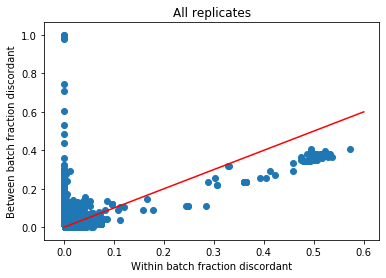

In [19]:
x = (results['B1_AllRep_Concordance'] + results['B2_AllRep_Concordance']) / (results['B1_AllRep_Total'] + results['B2_AllRep_Total'])
#x = results['B1_AllRep_Concordance'] / results['B1_AllRep_Total']
y = results['Between_AllRep_Concordance'] / results['Between_AllRep_Total']
ind = (x>0) | (y>0)
plt.scatter(x.loc[ind], y.loc[ind])
plt.plot([0,.6], [0,.6], color='r')

plt.xlabel('Within batch fraction discordant')
plt.ylabel('Between batch fraction discordant')
plt.title('All replicates')

Text(0.5, 1.0, 'Deduplicated replicates')

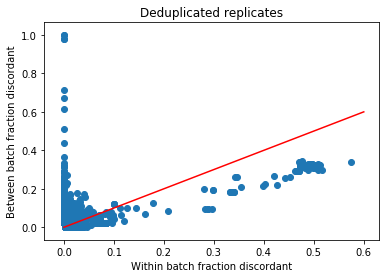

In [20]:
x = (results['B1_Dedup_Concordance'] + results['B2_Dedup_Concordance']) / (results['B1_Dedup_Total'] + results['B2_Dedup_Total'])
#x = results['B1_AllRep_Concordance'] / results['B1_AllRep_Total']
y = results['Between_Dedup_Concordance'] / results['Between_Dedup_Total']
ind = (x>0) | (y>0)
plt.scatter(x.loc[ind], y.loc[ind])
plt.plot([0,.6], [0,.6], color='r')
plt.xlabel('Within batch fraction discordant')
plt.ylabel('Between batch fraction discordant')
plt.title('Deduplicated replicates')

In [21]:
results.head()

,B1_AllRep_Concordance,B1_Dedup_Concordance,B1_AllRep_Total,B1_Dedup_Total,B2_AllRep_Concordance,B2_Dedup_Concordance,B2_AllRep_Total,B2_Dedup_Total,Between_AllRep_Concordance,Between_Dedup_Concordance,Between_AllRep_Total,Between_Dedup_Total
1:54676:A:G,0.0,0.0,100.0,71,0.0,0.0,205.0,124,0.0,0.0,66.0,49
1:108310:A:G,0.0,0.0,95.0,68,0.0,0.0,212.0,124,0.0,0.0,62.0,45
1:256586:A:C,0.0,0.0,100.0,71,0.0,0.0,207.0,124,0.0,0.0,65.0,48
1:534247:A:G,0.0,0.0,99.0,70,0.0,0.0,213.0,125,0.0,0.0,65.0,48
1:723918:A:G,0.0,0.0,100.0,71,0.0,0.0,214.0,126,0.0,0.0,66.0,49


In [22]:
resultsfn = '../../data/tmp/plink/H3/BroadPost2016_H3_B1and2_UpdateSexandID.Coord.RefAllele.NoMulti.NoSexDisc.mDupVars.DuplicateDiscrepancyCounts.tsv'
results.to_csv(resultsfn, sep='\t')

In [14]:
resultsfn = '../../data/tmp/plink/H3/BroadPost2016_H3_B1and2_UpdateSexandID.Coord.RefAllele.NoMulti.NoSexDisc.mDupVars.DuplicateDiscrepancyCounts.tsv'

results = pd.read_csv(resultsfn, sep='\t', index_col=0)
results.head()

,B1_AllRep_Concordance,B1_Dedup_Concordance,B1_AllRep_Total,B1_Dedup_Total,B2_AllRep_Concordance,B2_Dedup_Concordance,B2_AllRep_Total,B2_Dedup_Total,Between_AllRep_Concordance,Between_Dedup_Concordance,Between_AllRep_Total,Between_Dedup_Total
1:54676:A:G,0.0,0.0,100.0,71,0.0,0.0,205.0,124,0.0,0.0,66.0,49
1:108310:A:G,0.0,0.0,95.0,68,0.0,0.0,212.0,124,0.0,0.0,62.0,45
1:256586:A:C,0.0,0.0,100.0,71,0.0,0.0,207.0,124,0.0,0.0,65.0,48
1:534247:A:G,0.0,0.0,99.0,70,0.0,0.0,213.0,125,0.0,0.0,65.0,48
1:723918:A:G,0.0,0.0,100.0,71,0.0,0.0,214.0,126,0.0,0.0,66.0,49


In [15]:
a = '../../data/tmp/plink/H3/BroadPost2016_H3_B1and2_UpdateSexandID.Coord.RefAllele.NoMulti.NoSexDisc.mDupVars.renamesexchr.sorted.fixPloidy'

## Check missingness

In [25]:
cmd = 'plink --missing --bfile {a} --out {a}'.format(a=a)
print(cmd)
!{cmd}

plink --missing --bfile ../../data/tmp/plink/H3/BroadPost2016_H3_B1and2_UpdateSexandID.Coord.RefAllele.NoMulti.NoSexDisc.mDupVars.renamesexchr.sorted.fixPloidy --out ../../data/tmp/plink/H3/BroadPost2016_H3_B1and2_UpdateSexandID.Coord.RefAllele.NoMulti.NoSexDisc.mDupVars.renamesexchr.sorted.fixPloidy
PLINK v1.90b4 64-bit (20 Mar 2017)             www.cog-genomics.org/plink/1.9/
(C) 2005-2017 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to ../../data/tmp/plink/H3/BroadPost2016_H3_B1and2_UpdateSexandID.Coord.RefAllele.NoMulti.NoSexDisc.mDupVars.renamesexchr.sorted.fixPloidy.log.
Options in effect:
  --bfile ../../data/tmp/plink/H3/BroadPost2016_H3_B1and2_UpdateSexandID.Coord.RefAllele.NoMulti.NoSexDisc.mDupVars.renamesexchr.sorted.fixPloidy
  --missing
  --out ../../data/tmp/plink/H3/BroadPost2016_H3_B1and2_UpdateSexandID.Coord.RefAllele.NoMulti.NoSexDisc.mDupVars.renamesexchr.sorted.fixPloidy

128934 MB RAM detected; reserving 64467 MB for main workspace.
199

In [26]:
varmiss = pd.read_csv('{a}.lmiss'.format(a=a), sep='\s+')
vc = varmiss['N_MISS'].value_counts()
vc.loc[vc.index>500].head()

1319    190
1318    164
1320    154
1322    149
1323    148
Name: N_MISS, dtype: int64

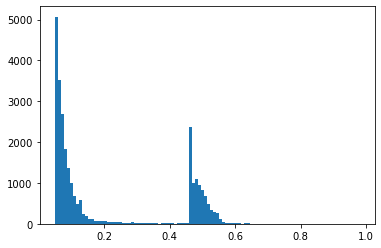

In [27]:
_ = plt.hist(varmiss.loc[varmiss['F_MISS']>.05, 'F_MISS'], bins=100)

## Allele frequency association approach

In [28]:
a

'../../data/tmp/plink/H3/BroadPost2016_H3_B1and2_UpdateSexandID.Coord.RefAllele.NoMulti.NoSexDisc.mDupVars.renamesexchr.sorted.fixPloidy'

In [29]:
dupstofilter = list(postpost.loc[postpost['IID'] != postpost['Duplicate_To_Use'], 'IID'])
idfile = '../../data/tmp/plink/H3/BroadPost2016_H3_B1and2_dupstofilter.txt'

fam = pd.read_csv(a+'.fam', sep='\t', header=None)
fam.index = fam[1]
dupstofilter = list(set(dupstofilter).intersection(fam[1]))
fam.loc[dupstofilter, [0,1]].to_csv(idfile, sep='\t', index=None, header=None)

In [16]:
phenofn = 'gs://popgen-gwas/data/metadata/Annotated_GenotypedData/preANDpost2016_Merged_Complete_Metadata_WithAge_20210818.tsv'
phenoinfo = pd.read_csv(phenofn, sep='\t')
phenoinfo.index = phenoinfo['Full_IID']

group_fn = 'gs://popgen-gwas/data/metadata/Annotated_GenotypedData/OmniH3Merged_PrePost2016_AggregatedLASVPhenotypes_20210829.tsv'
groups = pd.read_csv(group_fn, sep='\t')
groups.index = groups['#IID']
ind = groups.index[groups['Post2016_NG_LASV_qPCR2xPosOrSeqPos'] | groups['Post2016_NG_LASV_SeqPos'] | groups['Pre2016_NG_LASV_SeqPos'] | groups['Pre2016_SL_LASV_AgORSeqPos'] | groups['Post2016_SL_LASV_AgPos']]
phenoinfo['LASV_Case'] = 0
phenoinfo.loc[ind, 'LASV_Case'] = 1


phenoinfo.head().T

Full_IID,July2014NG_SM-6C4M9,July2014NG_SM-4XBS9,July2014NG_SM-6C4MA,July2014NG_SM-6C4MB,July2014NG_SM-4XBSM
Full_IID,July2014NG_SM-6C4M9,July2014NG_SM-4XBS9,July2014NG_SM-6C4MA,July2014NG_SM-6C4MB,July2014NG_SM-4XBSM
Genotype_Sex,1,2,1,2,2
ID_Reformat,SM-6C4M9,SM-4XBS9,SM-6C4MA,SM-6C4MB,SM-4XBSM
SampleType,SuspectedLassaNG,Pre2016ControlNG,SuspectedLassaNG,SuspectedLassaNG,Pre2016ControlNG
sex,1,2,1,2,2
Disease,Lassa,Lassa,Lassa,Lassa,Lassa
ISTH_SandR_Key,NaN,NaN,NaN,NaN,NaN
KGH_Survivor_Key,NaN,NaN,NaN,NaN,NaN
KGH_AcuteLassa_Key,NaN,NaN,NaN,NaN,NaN
KGH_AcuteEbola_Key,NaN,NaN,NaN,NaN,NaN


In [17]:
groups.columns

Index(['#IID', 'SEX', 'Batch', 'SampleType', 'CollectionEpoch', 'Disease',
       'Epoch', 'Epoch_Bin', 'Country', 'Age', 'Post2016_NG_LASV_SeqPos',
       'Post2016_NG_LASV_qPCR2xPos', 'Post2016_NG_LASV_qPCR1xPosOrSeqPos',
       'Post2016_NG_LASV_qPCR2xPosOrSeqPos', 'Post2016_NG_LASV_qPCR1xNeg',
       'Post2016_NG_LASV_qPCR2xNeg', 'Post2016_NG_LASV_rtpcrNeg',
       'Post2016_NG_LASV_PopControl', 'S&R_NG_LASV_Died', 'S&R_NG_LASV_DC',
       'Post2016_NG_LASV_qPCR2xPosOrSeqPos_Died',
       'Post2016_NG_LASV_qPCR2xPosOrSeqPos_DC', 'Pre2016_NG_LASV_qPCR1xPos',
       'Pre2016_NG_LASV_SeqPos', 'Pre2016_NG_LASV_Died', 'Pre2016_NG_LASV_DC',
       'Pre2016_NG_LASV_qPCRorSeq+_Died', 'Pre2016_NG_LASV_qPCRorSeq+_DC',
       'Pre2016_NG_LASV_PopControl', 'Pre2016_SL_LASV_qPCR1xPos',
       'Pre2016_SL_LASV_SeqPos', 'Pre2016_SL_LASV_AgPos',
       'Pre2016_SL_LASV_AgORSeqPos', 'Pre2016_SL_LASV_PopControl',
       'SL_LASV_Died', 'SL_LASV_DC', 'Post2016_SL_LASV_AgPos',
       'Pre2016_SL_LASV_

In [18]:
p = 'batch'
outfn = a+'.{p}'.format(p=p)
outfn

'../../data/tmp/plink/H3/BroadPost2016_H3_B1and2_UpdateSexandID.Coord.RefAllele.NoMulti.NoSexDisc.mDupVars.renamesexchr.sorted.fixPloidy.batch'

In [33]:


filt_cmd = 'plink --make-bed --bfile {inv} --out {ofn} --keep-allele-order --remove {filtfn}'.format(inv=a, ofn=outfn, filtfn=idfile)
print(filt_cmd)
!{filt_cmd}

#produce a pruned subset of markers that are in approximate linkage equilibrium with each other
prunefn = outfn + 'prune.ld_3e-1.maf_1e-1'
prune_cmd = 'plink --bfile {adat} --out {adatout} --indep-pairwise 1000kb 1 .3 --maf .1 --hwe 1e-12 --geno .1'.format(adat=outfn, adatout=prunefn)
print(prune_cmd)
!{prune_cmd}

#do PCA
pca_cmd = 'plink --bfile {adat} --out {adatout} --pca 20 --extract {adatout}.prune.in'.format(adat=outfn, adatout=prunefn)
print(pca_cmd)
!{pca_cmd}

#make square relationship matrix 
relbase = outfn + '.prune.ld_3e-1.maf_1e-1'
rel_cmd = 'plink --make-rel square --bfile {adat} --out {adatout} --extract {prune}.prune.in'.format(adat=outfn, adatout=relbase, prune=prunefn)
print(rel_cmd)
!{rel_cmd}

relid = pd.read_csv(relbase+'.rel.id', header=None, sep ='\t')[1].iloc[0:]
rel = pd.read_csv(relbase+'.rel', header=None, sep='\t')
print(relid)
rel.index = relid
rel.columns = relid
rel.to_csv(relbase+'.rel.withids.tsv', sep='\t')
del(rel)

plink --make-bed --bfile ../../data/tmp/plink/H3/BroadPost2016_H3_B1and2_UpdateSexandID.Coord.RefAllele.NoMulti.NoSexDisc.mDupVars.renamesexchr.sorted.fixPloidy --out ../../data/tmp/plink/H3/BroadPost2016_H3_B1and2_UpdateSexandID.Coord.RefAllele.NoMulti.NoSexDisc.mDupVars.renamesexchr.sorted.fixPloidy.batch --keep-allele-order --remove ../../data/tmp/plink/H3/BroadPost2016_H3_B1and2_dupstofilter.txt
PLINK v1.90b4 64-bit (20 Mar 2017)             www.cog-genomics.org/plink/1.9/
(C) 2005-2017 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to ../../data/tmp/plink/H3/BroadPost2016_H3_B1and2_UpdateSexandID.Coord.RefAllele.NoMulti.NoSexDisc.mDupVars.renamesexchr.sorted.fixPloidy.batch.log.
Options in effect:
  --bfile ../../data/tmp/plink/H3/BroadPost2016_H3_B1and2_UpdateSexandID.Coord.RefAllele.NoMulti.NoSexDisc.mDupVars.renamesexchr.sorted.fixPloidy
  --keep-allele-order
  --make-bed
  --out ../../data/tmp/plink/H3/BroadPost2016_H3_B1and2_UpdateSexandID.Coord.RefA

In [34]:
print(outfn)
cov = pd.read_csv(outfn+'.fam', sep=' ', header=None)
cov = cov[[0,1,5]]
cov.columns = ['FID', 'IID', 'Batch']
cov.index = cov['IID']
cov['Country'] = phenoinfo.loc[cov['IID'], 'Country'].replace({'NG':0, 'SL':1}).values
cov['Batch'] = phenoinfo.loc[cov['IID'], 'Batch'].replace({'2':1, '1':0}).values
cov['LASV_Case'] = phenoinfo.loc[cov['IID'], 'LASV_Case'].values
covfn = outfn + '.cov'
cov.to_csv(covfn, sep='\t', index=False)
cov.head()

../../data/tmp/plink/H3/BroadPost2016_H3_B1and2_UpdateSexandID.Coord.RefAllele.NoMulti.NoSexDisc.mDupVars.renamesexchr.sorted.fixPloidy.batch


,FID,IID,Batch,Country,LASV_Case
IID,,,,,
WG0284565-DNA_A03_G-5686,0,WG0284565-DNA_A03_G-5686,0,1,0
WG0341167-DNA_A03_1079-LV-18,0,WG0341167-DNA_A03_1079-LV-18,1,0,1
WG0284565-DNA_B02_G-5585,0,WG0284565-DNA_B02_G-5585,0,1,0
WG0341167-DNA_A05_0029-LV-18,0,WG0341167-DNA_A05_0029-LV-18,1,0,0
WG0284565-DNA_B12_G-7174,0,WG0284565-DNA_B12_G-7174,0,1,0


In [19]:
gcsdir = 'gs://popgen-gwas/data/analysis/Imputation_BatchCorrection/H3/'
outfn = '../../data/tmp/plink/H3/BroadPost2016_H3_B1and2_UpdateSexandID.Coord.RefAllele.NoMulti.NoSexDisc.mDupVars.renamesexchr.sorted.fixPloidy.batch'

In [36]:
cmd = 'gsutil -m cp %s.* %s' % (outfn, gcsdir)
print(cmd)
!{cmd}

gsutil -m cp ../../data/tmp/plink/H3/BroadPost2016_H3_B1and2_UpdateSexandID.Coord.RefAllele.NoMulti.NoSexDisc.mDupVars.renamesexchr.sorted.fixPloidy.batch.* gs://popgen-gwas/data/analysis/Imputation_BatchCorrection/H3/
Copying file://../../data/tmp/plink/H3/BroadPost2016_H3_B1and2_UpdateSexandID.Coord.RefAllele.NoMulti.NoSexDisc.mDupVars.renamesexchr.sorted.fixPloidy.batch.NG.Tokeep.txt [Content-Type=text/plain]...
Copying file://../../data/tmp/plink/H3/BroadPost2016_H3_B1and2_UpdateSexandID.Coord.RefAllele.NoMulti.NoSexDisc.mDupVars.renamesexchr.sorted.fixPloidy.batch.NG.bed [Content-Type=application/octet-stream]...
==> NOTE: You are uploading one or more large file(s), which would run
significantly faster if you enable parallel composite uploads. This
feature can be enabled by editing the
"parallel_composite_upload_threshold" value in your .boto
configuration file. However, note that if you do this large files will
be uploaded as `composite objects
<https://cloud.google.com/storage/

In [20]:
scriptfn = 'gs://ebola-gwas-lbr/Code/run_GMMAT_fromPLINK_parallel.R'
container = 'quay.io/dkotliar/gmmat_mkl:0.4'
    
subcmdbase = '''dsub --project sabeti-ebola-gwas \
--name %s --provider google-v2 --min-ram 16 --min-cores 8 --boot-disk-size 600 --disk-size 1000 --zones "us-east1-b" \
--logging %s \
--image %s --ssh \
--input SCRIPT=%s \
--input BEDFILE=%s.bed \
--input FAMFILE=%s.fam \
--input BIMFILE=%s.bim \
--input COVFILE=%s.cov \
--input RELATFILE=%s \
--output NULLFILE=%s \
--output OUTFINAL=%s \
--env FORMULA='Batch ~ Country + LASV_Case + 1\' \
--env NCORES=7 \
--script submit.sh'''   

workingdir = gcsdir
localdir = '../../data/tmp/plink/H3/'

name = 'H3_BothCountries_CovCC'
logbase = os.path.join(workingdir, 'log', "{job-name}-{job-id}.log")    

bedbase = outfn.replace(localdir, workingdir)
relfile = bedbase + '.prune.ld_3e-1.maf_1e-1.rel.withids.tsv'
nulloutfile = bedbase + ".nullmodelCovCC.rds"
outfinal = bedbase + ".resultsCovCC.tsv"

fullcmd = subcmdbase % (name,logbase,container,scriptfn, bedbase, bedbase, bedbase, bedbase, relfile, nulloutfile, outfinal)        
fullcmd

'dsub --project sabeti-ebola-gwas --name H3_BothCountries_CovCC --provider google-v2 --min-ram 16 --min-cores 8 --boot-disk-size 600 --disk-size 1000 --zones "us-east1-b" --logging gs://popgen-gwas/data/analysis/Imputation_BatchCorrection/H3/log/{job-name}-{job-id}.log --image quay.io/dkotliar/gmmat_mkl:0.4 --ssh --input SCRIPT=gs://ebola-gwas-lbr/Code/run_GMMAT_fromPLINK_parallel.R --input BEDFILE=gs://popgen-gwas/data/analysis/Imputation_BatchCorrection/H3/BroadPost2016_H3_B1and2_UpdateSexandID.Coord.RefAllele.NoMulti.NoSexDisc.mDupVars.renamesexchr.sorted.fixPloidy.batch.bed --input FAMFILE=gs://popgen-gwas/data/analysis/Imputation_BatchCorrection/H3/BroadPost2016_H3_B1and2_UpdateSexandID.Coord.RefAllele.NoMulti.NoSexDisc.mDupVars.renamesexchr.sorted.fixPloidy.batch.fam --input BIMFILE=gs://popgen-gwas/data/analysis/Imputation_BatchCorrection/H3/BroadPost2016_H3_B1and2_UpdateSexandID.Coord.RefAllele.NoMulti.NoSexDisc.mDupVars.renamesexchr.sorted.fixPloidy.batch.bim --input COVFILE=g

In [38]:
!{fullcmd}

Job properties:
  job-id: h3-bothcou--dkotliar--220107-164534-03
  job-name: h3-bothcountries-covcc
  user-id: dkotliar
Provider internal-id (operation): projects/sabeti-ebola-gwas/operations/11630733945095150928
Launched job-id: h3-bothcou--dkotliar--220107-164534-03
To check the status, run:
  dstat --provider google-v2 --project sabeti-ebola-gwas --jobs 'h3-bothcou--dkotliar--220107-164534-03' --users 'dkotliar' --status '*'
To cancel the job, run:
  ddel --provider google-v2 --project sabeti-ebola-gwas --jobs 'h3-bothcou--dkotliar--220107-164534-03' --users 'dkotliar'
h3-bothcou--dkotliar--220107-164534-03


In [3]:
! dstat --provider google-v2 --project sabeti-ebola-gwas --jobs 'h3-bothcou--dkotliar--220107-164534-03' --users 'dkotliar' --status '*'

Job Name         Status    Last Update
---------------  --------  --------------
h3-bothcount...  Success   01-07 17:44:59



In [21]:

        
for fn in [nulloutfile, outfinal]:
    cmd = 'gsutil -m cp %s %s' % (fn, localdir)
    print(cmd)
    !{cmd}

gsutil -m cp gs://popgen-gwas/data/analysis/Imputation_BatchCorrection/H3/BroadPost2016_H3_B1and2_UpdateSexandID.Coord.RefAllele.NoMulti.NoSexDisc.mDupVars.renamesexchr.sorted.fixPloidy.batch.nullmodelCovCC.rds ../../data/tmp/plink/H3/
Copying gs://popgen-gwas/data/analysis/Imputation_BatchCorrection/H3/BroadPost2016_H3_B1and2_UpdateSexandID.Coord.RefAllele.NoMulti.NoSexDisc.mDupVars.renamesexchr.sorted.fixPloidy.batch.nullmodelCovCC.rds...
- [1/1 files][ 46.6 MiB/ 46.6 MiB] 100% Done                                    
Operation completed over 1 objects/46.6 MiB.                                     
gsutil -m cp gs://popgen-gwas/data/analysis/Imputation_BatchCorrection/H3/BroadPost2016_H3_B1and2_UpdateSexandID.Coord.RefAllele.NoMulti.NoSexDisc.mDupVars.renamesexchr.sorted.fixPloidy.batch.resultsCovCC.tsv ../../data/tmp/plink/H3/
Copying gs://popgen-gwas/data/analysis/Imputation_BatchCorrection/H3/BroadPost2016_H3_B1and2_UpdateSexandID.Coord.RefAllele.NoMulti.NoSexDisc.mDupVars.renames

In [22]:
outfile = "../../data/tmp/plink/H3/BroadPost2016_H3_B1and2_UpdateSexandID.Coord.RefAllele.NoMulti.NoSexDisc.mDupVars.renamesexchr.sorted.fixPloidy.batch.resultsCovCC.tsv"
mlmares = pd.read_csv(outfile, sep='\t')
#mlmares.columns = ['SNP', 'CHR', 'POS', 'REF', 'ALT', 'N', 'MISSRATE', 'AF', 'SCORE', 'VAR', 'PVAL']
mlmares.head()

/opt/miniconda3/envs/py36/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,SNP,CHR,POS,REF,ALT,N,MISSRATE,AF,SCORE,VAR,PVAL
0,1:108310:A:G,1,108310,T,C,2466,0.020651,0.000406,-0.148493,0.130754,0.681324
1,1:256586:A:C,1,256586,T,G,2499,0.007546,0.054022,1.501415,14.094425,0.689213
2,1:534247:A:G,1,534247,C,T,2507,0.004369,0.045074,-6.229748,13.018543,0.084241
3,1:723918:A:G,1,723918,G,A,2509,0.003574,0.095257,1.606138,23.523179,0.740525
4,1:728951:A:G,1,728951,C,T,2506,0.004766,0.136872,3.705760,32.920256,0.518363


In [23]:
mlmares.index = mlmares['SNP']
mlmares.head()

,SNP,CHR,POS,REF,ALT,N,MISSRATE,AF,SCORE,VAR,PVAL
SNP,,,,,,,,,,,
1:108310:A:G,1:108310:A:G,1,108310,T,C,2466,0.020651,0.000406,-0.148493,0.130754,0.681324
1:256586:A:C,1:256586:A:C,1,256586,T,G,2499,0.007546,0.054022,1.501415,14.094425,0.689213
1:534247:A:G,1:534247:A:G,1,534247,C,T,2507,0.004369,0.045074,-6.229748,13.018543,0.084241
1:723918:A:G,1:723918:A:G,1,723918,G,A,2509,0.003574,0.095257,1.606138,23.523179,0.740525
1:728951:A:G,1:728951:A:G,1,728951,C,T,2506,0.004766,0.136872,3.705760,32.920256,0.518363


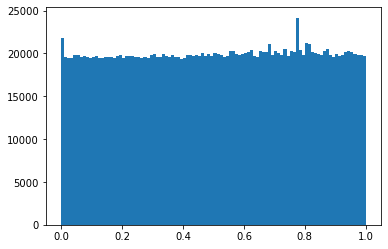

In [24]:
_ = plt.hist(mlmares['PVAL'], bins=100)

In [25]:
results['MLMA_P'] = np.nan
overlap = list(set(results.index).intersection(set(mlmares.index)))
results.loc[overlap, 'MLMA_P'] = mlmares.loc[overlap, 'PVAL'].values


In [26]:
ind = ~results['MLMA_P'].isnull()
results.loc[:, 'MLMA_Q'] = np.nan
results.loc[ind, 'MLMA_Q'] =fdrcorrection(results.loc[ind, 'MLMA_P'], method='indep')[1]

In [27]:
results.loc[:, 'MLMA_logP'] = results.loc[:, 'MLMA_P'].apply(np.log10)*-1
results.loc[:, 'MLMA_logQ'] = results.loc[:, 'MLMA_Q'].apply(np.log10)*-1

ind = results['MLMA_logP']>20
results.loc[ind, 'MLMA_logP']=20

ind = results['MLMA_logQ']>20
results.loc[ind, 'MLMA_logQ']=20

In [28]:
results['Between_AllRep_FracConcordant'] = results['Between_AllRep_Concordance'] / results['Between_AllRep_Total']
results['Within_AllRep_FracConcordant']  = (results['B1_AllRep_Concordance'] + results['B2_AllRep_Concordance']) / (results['B1_AllRep_Total'] + results['B2_AllRep_Total'])


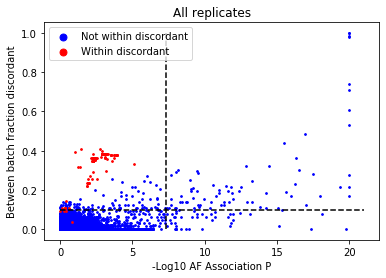

In [29]:
x = results['MLMA_logP']
y = results['Between_AllRep_FracConcordant']
ind = ~x.isnull()
iswithindisc = (results['Within_AllRep_FracConcordant']>0.1)

plt.scatter(x.loc[ind & ~iswithindisc], y.loc[ind & ~iswithindisc], s=3, color='b', label='Not within discordant')
plt.scatter(x.loc[ind & iswithindisc], y.loc[ind & iswithindisc], s=3, color='r', label='Within discordant')
plt.legend(loc='upper left', markerscale=4)
plt.xlabel('-Log10 AF Association P')
plt.ylabel('Between batch fraction discordant')
plt.title('All replicates')
plt.hlines(y=.1, xmin=0, xmax=21, linestyle='--')
plt.vlines(x=-1*np.log10(5*(10**-8)), ymin=0, ymax=1, linestyle='--')

In [30]:
pd.crosstab(x.loc[ind]>-1*np.log10(5*(10**-8)), y.loc[ind]>.1)

Between_AllRep_FracConcordant,False,True
MLMA_logP,,
False,1991877,309
True,45,75


Text(0.5, 1.0, 'All replicates')

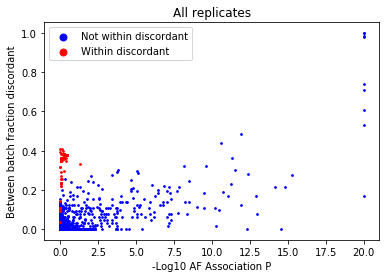

In [31]:
x = results['MLMA_logQ']
y = results['Between_AllRep_FracConcordant']
ind = ~x.isnull()

iswithindisc = (results['Within_AllRep_FracConcordant']>0.1)
plt.scatter(x.loc[ind & ~iswithindisc], y.loc[ind & ~iswithindisc], s=3, color='b', label='Not within discordant')
plt.scatter(x.loc[ind & iswithindisc], y.loc[ind & iswithindisc], s=3, color='r', label='Within discordant')
plt.legend(loc='upper left', markerscale=4)
plt.xlabel('-Log10 AF Association P')
plt.ylabel('Between batch fraction discordant')
plt.title('All replicates')

(-1, 10)

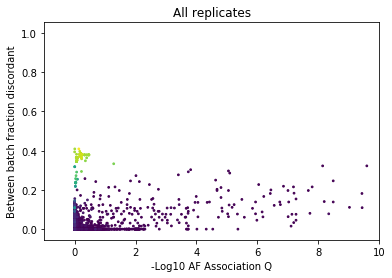

In [32]:
z = results.sort_values(by='Within_AllRep_FracConcordant', ascending=True)
x = z['MLMA_logQ']
y = z['Between_AllRep_FracConcordant']
ind = ~x.isnull()



iswithindisc = z['Within_AllRep_FracConcordant']
plt.scatter(x.loc[ind], y.loc[ind], s=3, c=iswithindisc.loc[ind])
plt.xlabel('-Log10 AF Association Q')
plt.ylabel('Between batch fraction discordant')
plt.title('All replicates')
plt.xlim([-1,10])

Text(0.5, 1.0, 'All replicates')

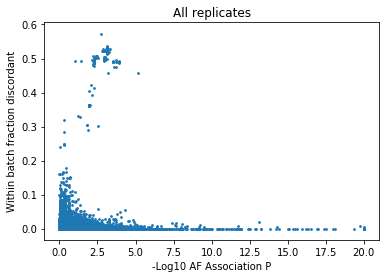

In [33]:
x = results['MLMA_logP']
y = results['Within_AllRep_FracConcordant']
ind = ~x.isnull()
plt.scatter(x.loc[ind], y.loc[ind], s=3)

plt.xlabel('-Log10 AF Association P')
plt.ylabel('Within batch fraction discordant')
plt.title('All replicates')

In [34]:
ind = (results['Between_AllRep_FracConcordant']>0.05) & (results['Between_AllRep_FracConcordant']<.1)  & (results['MLMA_logP']<.1)
results.loc[ind, :].sort_values(by='Within_AllRep_FracConcordant', ascending=True).head(10)

,B1_AllRep_Concordance,B1_Dedup_Concordance,B1_AllRep_Total,B1_Dedup_Total,B2_AllRep_Concordance,B2_Dedup_Concordance,B2_AllRep_Total,B2_Dedup_Total,Between_AllRep_Concordance,Between_Dedup_Concordance,Between_AllRep_Total,Between_Dedup_Total,MLMA_P,MLMA_Q,MLMA_logP,MLMA_logQ,Between_AllRep_FracConcordant,Within_AllRep_FracConcordant
10:102697376:A:C,0.0,0.0,86.0,63,0.0,0.0,151.0,102,3.0,2.0,54.0,40,0.897492,0.999712,0.046969,0.000125,0.055556,0.0
16:75045187:A:G,0.0,0.0,95.0,66,0.0,0.0,186.0,115,3.0,1.0,59.0,44,0.971131,0.999762,0.012722,0.000103,0.050847,0.0
16:54164887:A:T,0.0,0.0,82.0,58,0.0,0.0,184.0,109,4.0,3.0,54.0,43,0.818203,0.999660,0.087139,0.000148,0.074074,0.0
16:85982246:A:G,0.0,0.0,86.0,63,0.0,0.0,186.0,112,3.0,2.0,55.0,45,0.837293,0.999660,0.077122,0.000148,0.054545,0.0
6:62712234:A:G,0.0,0.0,82.0,59,0.0,0.0,188.0,104,3.0,3.0,59.0,43,0.999041,0.999979,0.000417,0.000009,0.050847,0.0
23:54572804:A:G,0.0,0.0,88.0,65,0.0,0.0,168.0,100,5.0,3.0,56.0,43,0.899246,0.999712,0.046122,0.000125,0.089286,0.0
17:80272873:A:G,0.0,0.0,93.0,64,0.0,0.0,199.0,117,3.0,1.0,59.0,42,0.950651,0.999712,0.021979,0.000125,0.050847,0.0
3:184135845:A:C,0.0,0.0,74.0,55,0.0,0.0,179.0,108,4.0,3.0,45.0,38,0.856901,0.999660,0.067069,0.000148,0.088889,0.0
3:169380240:A:G,0.0,0.0,88.0,63,0.0,0.0,177.0,105,3.0,1.0,41.0,35,0.802607,0.999660,0.095497,0.000148,0.073171,0.0
3:116483775:A:G,0.0,0.0,94.0,65,0.0,0.0,186.0,113,3.0,1.0,54.0,43,0.935935,0.999712,0.028754,0.000125,0.055556,0.0


## Repeat for Nigeria and Sierra Leone separately

In [35]:
dupstofilter = list(postpost.loc[postpost['IID'] != postpost['Duplicate_To_Use'], 'IID'])

In [36]:
raw_adat = '../../data/tmp/plink/H3/BroadPost2016_H3_B1and2_UpdateSexandID.Coord.RefAllele.NoMulti.NoSexDisc.mDupVars.renamesexchr.sorted.fixPloidy'
p = 'batch'

In [37]:


for country in ['NG', 'SL']:
    a = raw_adat+'.{p}.{c}'.format(p=p, c=country)
    fam = pd.read_csv(raw_adat+'.fam', sep='\t', header=None)
    fam.index = fam[1]
    keep = (phenoinfo.loc[fam.index, 'Country']==country) & ~fam.index.isin(dupstofilter)    
    fam = fam.loc[keep,:]
    keepfn = '{a}.Tokeep.txt'.format(a=a)
    print(keepfn)
    fam.to_csv(keepfn, sep='\t', index=False)
    filt_cmd = 'plink --make-bed --bfile {inv} --out {ofn} --keep-allele-order --keep {keep}'.format(inv=raw_adat, ofn = a, keep=keepfn)
    print(filt_cmd)
    !{filt_cmd}    
    
    #produce a pruned subset of markers that are in approximate linkage equilibrium with each other
    prunefn = a + '.prune.ld_3e-1.maf_1e-1'
    prune_cmd = 'plink --bfile {a} --out {prune} --indep-pairwise 1000kb 1 .3 --maf .1  --hwe 1e-12 --geno .1'.format(a=a, prune=prunefn)
    print(prune_cmd)
    !{prune_cmd}

    #do PCA
    pca_cmd = 'plink --bfile {a} --out {prune} --pca 20 --extract {prune}.prune.in'.format(a=a, prune=prunefn)
    print(pca_cmd)
    !{pca_cmd}
    
    #make square relationship matrix 
    relbase = prunefn
    rel_cmd = 'plink --make-rel square --bfile {a} --out {rel} --extract {prune}.prune.in'.format(a=a, rel=relbase, prune=prunefn)
    print(rel_cmd)
    !{rel_cmd}

    relid = pd.read_csv(relbase+'.rel.id', header=None, sep ='\t')[1].iloc[0:]
    rel = pd.read_csv(relbase+'.rel', header=None, sep='\t')
    print(relid)
    rel.index = relid
    rel.columns = relid
    relfn = relbase+'.rel.withids.tsv'
    rel.to_csv(relfn, sep='\t')    
    cov = pd.read_csv(a+'.fam', sep=' ', header=None)
    cov = cov[[0,1,5]]
    cov.columns = ['FID', 'IID', 'Batch']
    cov.index = cov['IID']
    cov['Country'] = phenoinfo.loc[cov['IID'], 'Country'].replace({'NG':0, 'SL':1}).values
    cov['Batch'] = phenoinfo.loc[cov['IID'], 'Batch'].replace({'2':1, '1':0}).values
    cov['LASV_Case'] = phenoinfo.loc[cov['IID'], 'LASV_Case'].values
    covfn = a + '.cov'
    cov.to_csv(covfn, sep='\t', index=False)
    
    '''
    ncores = 6
    bedbase = a+'.bed'
    formula = '"Batch ~ 1"'
    nulloutfile = "{a}.nullmodel.rds".format(a=a)
    outfile = "{a}.results.tsv".format(a=a)
    cmd = 'Rscript --vanilla ../../code/gwas_analysis/run_GMMAT_fromPLINK.R %s %s %s %s %s %s %d' % (covfn, bedbase, relfn, formula, nulloutfile, outfile, ncores)
    print(cmd)
    !{cmd}
    '''

../../data/tmp/plink/H3/BroadPost2016_H3_B1and2_UpdateSexandID.Coord.RefAllele.NoMulti.NoSexDisc.mDupVars.renamesexchr.sorted.fixPloidy.batch.NG.Tokeep.txt
plink --make-bed --bfile ../../data/tmp/plink/H3/BroadPost2016_H3_B1and2_UpdateSexandID.Coord.RefAllele.NoMulti.NoSexDisc.mDupVars.renamesexchr.sorted.fixPloidy --out ../../data/tmp/plink/H3/BroadPost2016_H3_B1and2_UpdateSexandID.Coord.RefAllele.NoMulti.NoSexDisc.mDupVars.renamesexchr.sorted.fixPloidy.batch.NG --keep-allele-order --keep ../../data/tmp/plink/H3/BroadPost2016_H3_B1and2_UpdateSexandID.Coord.RefAllele.NoMulti.NoSexDisc.mDupVars.renamesexchr.sorted.fixPloidy.batch.NG.Tokeep.txt
PLINK v1.90b4 64-bit (20 Mar 2017)             www.cog-genomics.org/plink/1.9/
(C) 2005-2017 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to ../../data/tmp/plink/H3/BroadPost2016_H3_B1and2_UpdateSexandID.Coord.RefAllele.NoMulti.NoSexDisc.mDupVars.renamesexchr.sorted.fixPloidy.batch.NG.log.
Options in effect:
  --bfile .

In [38]:
gcsdir = 'gs://popgen-gwas/data/analysis/Imputation_BatchCorrection/H3/'
for country in ['NG', 'SL']:
    outfn = raw_adat+'.{p}.{c}'.format(p=p, c=country)
    print(outfn)
    cmd = 'gsutil -m cp %s.* %s' % (outfn, gcsdir)
    print(cmd)
    !{cmd}

../../data/tmp/plink/H3/BroadPost2016_H3_B1and2_UpdateSexandID.Coord.RefAllele.NoMulti.NoSexDisc.mDupVars.renamesexchr.sorted.fixPloidy.batch.NG
gsutil -m cp ../../data/tmp/plink/H3/BroadPost2016_H3_B1and2_UpdateSexandID.Coord.RefAllele.NoMulti.NoSexDisc.mDupVars.renamesexchr.sorted.fixPloidy.batch.NG.* gs://popgen-gwas/data/analysis/Imputation_BatchCorrection/H3/
Copying file://../../data/tmp/plink/H3/BroadPost2016_H3_B1and2_UpdateSexandID.Coord.RefAllele.NoMulti.NoSexDisc.mDupVars.renamesexchr.sorted.fixPloidy.batch.NG.bed [Content-Type=application/octet-stream]...
Copying file://../../data/tmp/plink/H3/BroadPost2016_H3_B1and2_UpdateSexandID.Coord.RefAllele.NoMulti.NoSexDisc.mDupVars.renamesexchr.sorted.fixPloidy.batch.NG.Tokeep.txt [Content-Type=text/plain]...
Copying file://../../data/tmp/plink/H3/BroadPost2016_H3_B1and2_UpdateSexandID.Coord.RefAllele.NoMulti.NoSexDisc.mDupVars.renamesexchr.sorted.fixPloidy.batch.NG.hh [Content-Type=text/x-c++hdr]...
==> NOTE: You are uploading one

In [39]:
scriptfn = 'gs://ebola-gwas-lbr/Code/run_GMMAT_fromPLINK_parallel.R'
container = 'quay.io/dkotliar/gmmat_mkl:0.4'
    
subcmdbase = '''dsub --project sabeti-ebola-gwas \
--name %s --provider google-v2 --min-ram 16 --min-cores 8 --boot-disk-size 600 --disk-size 1000 --zones "us-east1-b" \
--logging %s \
--image %s --ssh \
--input SCRIPT=%s \
--input BEDFILE=%s.bed \
--input FAMFILE=%s.fam \
--input BIMFILE=%s.bim \
--input COVFILE=%s.cov \
--input RELATFILE=%s \
--output NULLFILE=%s \
--output OUTFINAL=%s \
--env FORMULA='Batch ~ LASV_Case + 1\' \
--env NCORES=7 \
--script submit.sh'''   

workingdir = gcsdir
localdir = '../../data/tmp/plink/H3/'

logbase = os.path.join(workingdir, 'log', "{job-name}-{job-id}.log")    
fullcmds = []
for country in ['NG', 'SL']:
    name = 'H3_%s_CovCC_minfilt' % country
    outfn = raw_adat+'.{p}.{c}'.format(p=p, c=country)
    bedbase = outfn.replace(localdir, workingdir)
    relfile = bedbase + '.prune.ld_3e-1.maf_1e-1.rel.withids.tsv'
    nulloutfile = bedbase + ".nullmodelCovCC.rds"
    outfinal = bedbase + ".resultsCovCC.tsv"

    fullcmd = subcmdbase % (name,logbase,container,scriptfn, bedbase, bedbase, bedbase, bedbase, relfile, nulloutfile, outfinal)        
    print(fullcmd)
    fullcmds.append(fullcmd)

dsub --project sabeti-ebola-gwas --name H3_NG_CovCC_minfilt --provider google-v2 --min-ram 16 --min-cores 8 --boot-disk-size 600 --disk-size 1000 --zones "us-east1-b" --logging gs://popgen-gwas/data/analysis/Imputation_BatchCorrection/H3/log/{job-name}-{job-id}.log --image quay.io/dkotliar/gmmat_mkl:0.4 --ssh --input SCRIPT=gs://ebola-gwas-lbr/Code/run_GMMAT_fromPLINK_parallel.R --input BEDFILE=gs://popgen-gwas/data/analysis/Imputation_BatchCorrection/H3/BroadPost2016_H3_B1and2_UpdateSexandID.Coord.RefAllele.NoMulti.NoSexDisc.mDupVars.renamesexchr.sorted.fixPloidy.batch.NG.bed --input FAMFILE=gs://popgen-gwas/data/analysis/Imputation_BatchCorrection/H3/BroadPost2016_H3_B1and2_UpdateSexandID.Coord.RefAllele.NoMulti.NoSexDisc.mDupVars.renamesexchr.sorted.fixPloidy.batch.NG.fam --input BIMFILE=gs://popgen-gwas/data/analysis/Imputation_BatchCorrection/H3/BroadPost2016_H3_B1and2_UpdateSexandID.Coord.RefAllele.NoMulti.NoSexDisc.mDupVars.renamesexchr.sorted.fixPloidy.batch.NG.bim --input COVF

In [40]:
for cmd in fullcmds:
    !{cmd}

Job properties:
  job-id: h3-ng-covc--dkotliar--220107-183419-46
  job-name: h3-ng-covcc-minfilt
  user-id: dkotliar
Provider internal-id (operation): projects/sabeti-ebola-gwas/operations/6147818264664771862
Launched job-id: h3-ng-covc--dkotliar--220107-183419-46
To check the status, run:
  dstat --provider google-v2 --project sabeti-ebola-gwas --jobs 'h3-ng-covc--dkotliar--220107-183419-46' --users 'dkotliar' --status '*'
To cancel the job, run:
  ddel --provider google-v2 --project sabeti-ebola-gwas --jobs 'h3-ng-covc--dkotliar--220107-183419-46' --users 'dkotliar'
h3-ng-covc--dkotliar--220107-183419-46
Job properties:
  job-id: h3-sl-covc--dkotliar--220107-183420-36
  job-name: h3-sl-covcc-minfilt
  user-id: dkotliar
Provider internal-id (operation): projects/sabeti-ebola-gwas/operations/8930313513792098573
Launched job-id: h3-sl-covc--dkotliar--220107-183420-36
To check the status, run:
  dstat --provider google-v2 --project sabeti-ebola-gwas --jobs 'h3-sl-covc--dkotliar--220107-1

In [43]:
! dstat --provider google-v2 --project sabeti-ebola-gwas --jobs 'h3-ng-covc--dkotliar--220107-183419-46' --users 'dkotliar' --status '*'


Job Name         Status    Last Update
---------------  --------  --------------
h3-ng-covcc-...  Success   01-07 19:15:12



In [44]:
! dstat --provider google-v2 --project sabeti-ebola-gwas --jobs 'h3-sl-covc--dkotliar--220107-183420-36' --users 'dkotliar' --status '*'


Job Name         Status    Last Update
---------------  --------  --------------
h3-sl-covcc-...  Success   01-07 19:21:15



In [45]:
! gsutil -m cp gs://popgen-gwas/data/analysis/Imputation_BatchCorrection/H3/BroadPost2016_H3_B1and2_UpdateSexandID.Coord.RefAllele.NoMulti.NoSexDisc.mDupVars.renamesexchr.sorted.fixPloidy.batch.NG.resultsCovCC.tsv ../../data/tmp/plink/H3/
! gsutil -m cp gs://popgen-gwas/data/analysis/Imputation_BatchCorrection/H3/BroadPost2016_H3_B1and2_UpdateSexandID.Coord.RefAllele.NoMulti.NoSexDisc.mDupVars.renamesexchr.sorted.fixPloidy.batch.NG.nullmodelCovCC.rds  ../../data/tmp/plink/H3/
! gsutil -m cp gs://popgen-gwas/data/analysis/Imputation_BatchCorrection/H3/BroadPost2016_H3_B1and2_UpdateSexandID.Coord.RefAllele.NoMulti.NoSexDisc.mDupVars.renamesexchr.sorted.fixPloidy.batch.SL.resultsCovCC.tsv ../../data/tmp/plink/H3/
! gsutil -m cp gs://popgen-gwas/data/analysis/Imputation_BatchCorrection/H3/BroadPost2016_H3_B1and2_UpdateSexandID.Coord.RefAllele.NoMulti.NoSexDisc.mDupVars.renamesexchr.sorted.fixPloidy.batch.SL.nullmodelCovCC.rds  ../../data/tmp/plink/H3/

Copying gs://popgen-gwas/data/analysis/Imputation_BatchCorrection/H3/BroadPost2016_H3_B1and2_UpdateSexandID.Coord.RefAllele.NoMulti.NoSexDisc.mDupVars.renamesexchr.sorted.fixPloidy.batch.NG.resultsCovCC.tsv...
/ [1/1 files][217.9 MiB/217.9 MiB] 100% Done                                    
Operation completed over 1 objects/217.9 MiB.                                    
Copying gs://popgen-gwas/data/analysis/Imputation_BatchCorrection/H3/BroadPost2016_H3_B1and2_UpdateSexandID.Coord.RefAllele.NoMulti.NoSexDisc.mDupVars.renamesexchr.sorted.fixPloidy.batch.NG.nullmodelCovCC.rds...
/ [1/1 files][  7.6 MiB/  7.6 MiB] 100% Done                                    
Operation completed over 1 objects/7.6 MiB.                                      
Copying gs://popgen-gwas/data/analysis/Imputation_BatchCorrection/H3/BroadPost2016_H3_B1and2_UpdateSexandID.Coord.RefAllele.NoMulti.NoSexDisc.mDupVars.renamesexchr.sorted.fixPloidy.batch.SL.resultsCovCC.tsv...
/ [1/1 files][218.3 MiB/218.3 MiB] 100% Do

In [46]:
import sys
sys.path.append('../../code/gwas_analysis')
from gwas_plotting import manhattan, qqplot

/opt/miniconda3/envs/py36/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


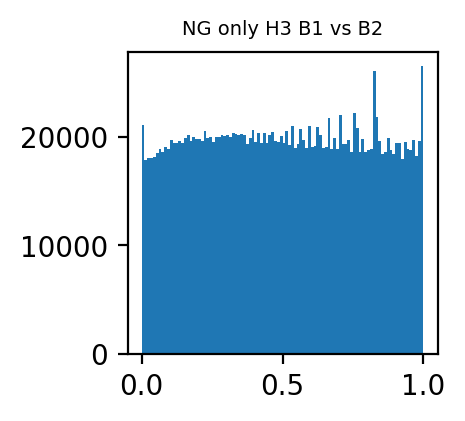

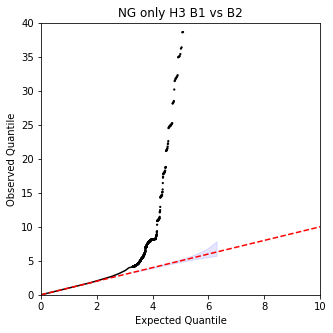

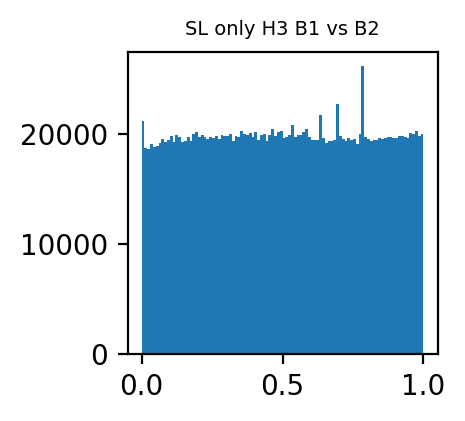

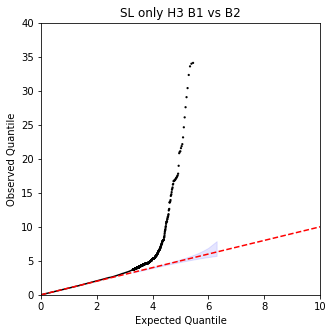

In [47]:
percountry_mlmares = {}
for country in ['NG', 'SL']:
    outfile = '../../data/tmp/plink/H3/BroadPost2016_H3_B1and2_UpdateSexandID.Coord.RefAllele.NoMulti.NoSexDisc.mDupVars.renamesexchr.sorted.fixPloidy.batch.{c}.resultsCovCC.tsv'.format(c=country)
    percountry_mlmares[country] = pd.read_csv(outfile, sep='\t')
    
    (fig,ax) = plt.subplots(1,1, figsize=(2,2), dpi=200)
    _ = ax.hist(percountry_mlmares[country]['PVAL'], bins=100)
    ax.set_title('%s only H3 B1 vs B2' % country, fontsize=7)
    
    ax = qqplot(percountry_mlmares[country]['PVAL'], title='%s only H3 B1 vs B2' % country)
    ax.set_xlim([0,10])
    ax.set_ylim([0,40])

In [48]:
results.head()

,B1_AllRep_Concordance,B1_Dedup_Concordance,B1_AllRep_Total,B1_Dedup_Total,B2_AllRep_Concordance,B2_Dedup_Concordance,B2_AllRep_Total,B2_Dedup_Total,Between_AllRep_Concordance,Between_Dedup_Concordance,Between_AllRep_Total,Between_Dedup_Total,MLMA_P,MLMA_Q,MLMA_logP,MLMA_logQ,Between_AllRep_FracConcordant,Within_AllRep_FracConcordant
1:54676:A:G,0.0,0.0,100.0,71,0.0,0.0,205.0,124,0.0,0.0,66.0,49,NaN,NaN,NaN,NaN,0.0,0.0
1:108310:A:G,0.0,0.0,95.0,68,0.0,0.0,212.0,124,0.0,0.0,62.0,45,0.681324,0.999660,0.166646,0.000148,0.0,0.0
1:256586:A:C,0.0,0.0,100.0,71,0.0,0.0,207.0,124,0.0,0.0,65.0,48,0.689213,0.999660,0.161647,0.000148,0.0,0.0
1:534247:A:G,0.0,0.0,99.0,70,0.0,0.0,213.0,125,0.0,0.0,65.0,48,0.084241,0.999501,1.074475,0.000217,0.0,0.0
1:723918:A:G,0.0,0.0,100.0,71,0.0,0.0,214.0,126,0.0,0.0,66.0,49,0.740525,0.999660,0.130460,0.000148,0.0,0.0


In [49]:
for country in ['NG', 'SL']:
    ind = percountry_mlmares[country]['SNP']
    percountry_mlmares[country].index = ind
    # Excludes chr25 variants
    overlap = list(set(ind).intersection(results.index))
    results['%s_MLMA_P' % country] = np.nan
    results.loc[overlap, '%s_MLMA_P' % country] = percountry_mlmares[country].loc[overlap, 'PVAL']
    print(country)
    display(pd.crosstab(results['MLMA_P']< 5e-8, results['%s_MLMA_P' % country]< 5e-8))
    display(pd.crosstab(results['MLMA_P']< 5e-6, results['%s_MLMA_P' % country]< 5e-6))

NG


NG_MLMA_P,False,True
MLMA_P,,
False,1992921,244
True,46,74


NG_MLMA_P,False,True
MLMA_P,,
False,1992652,372
True,142,119


SL


SL_MLMA_P,False,True
MLMA_P,,
False,1993132,33
True,56,64


SL_MLMA_P,False,True
MLMA_P,,
False,1992949,75
True,148,113


In [50]:
for v in ['MLMA_P', 'NG_MLMA_P', 'SL_MLMA_P']:
    ind = ~results[v].isnull()
    p = results.loc[ind, v].values
    (r,q) = fdrcorrection(p)  
    v2 = v.replace('_P', '_Q')
    results.loc[:,v2] = np.nan
    results.loc[ind,v2] = q

In [51]:
for v in ['MLMA_P', 'NG_MLMA_P', 'SL_MLMA_P']:
    ind = ~results[v].isnull()
    p = results.loc[ind, v].values
    (r,q) = fdrcorrection(p)  
    v2 = v.replace('_P', '_Q')
    results.loc[:,v2] = np.nan
    results.loc[ind,v2] = q

In [52]:
q_thresh = .5
discthresh = .1
tofilter = results.index[(results['MLMA_Q']<q_thresh) | (results['NG_MLMA_Q']<q_thresh) | (results['SL_MLMA_Q']<q_thresh) | (results['Between_AllRep_FracConcordant']>discthresh)]
len(tofilter)

5297

Text(0.5, 0, 'q-value threshold')

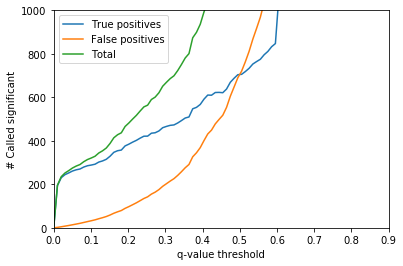

In [53]:
resx = []
for t in np.linspace(0, 1, 100):
    n = (results['MLMA_Q']<t).sum()
    fp = n*t
    tp = n - fp
    resx.append([t, n,fp, tp])
    
resx = pd.DataFrame(resx)

plt.plot(resx[0], resx[3], label='True positives')
plt.plot(resx[0], resx[2], label='False positives')
plt.plot(resx[0], resx[1], label='Total')

plt.xlim([0,.9])
plt.ylim([0,1000])
plt.legend()
plt.ylabel('# Called significant')
plt.xlabel('q-value threshold')

Text(0.5, 0, 'q-value threshold')

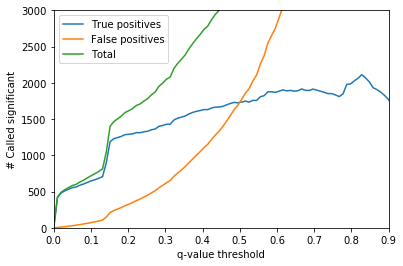

In [54]:
resx = []
for t in np.linspace(0, 1, 100):
    n = (results['NG_MLMA_Q']<t).sum()
    fp = n*t
    tp = n - fp
    resx.append([t, n,fp, tp])
    
resx = pd.DataFrame(resx)

plt.plot(resx[0], resx[3], label='True positives')
plt.plot(resx[0], resx[2], label='False positives')
plt.plot(resx[0], resx[1], label='Total')

plt.xlim([0,.9])
plt.ylim([0,3000])
plt.legend()
plt.ylabel('# Called significant')
plt.xlabel('q-value threshold')

Text(0.5, 0, 'q-value threshold')

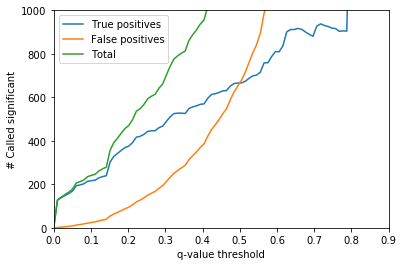

In [55]:
resx = []
for t in np.linspace(0, 1, 100):
    n = (results['SL_MLMA_Q']<t).sum()
    fp = n*t
    tp = n - fp
    resx.append([t, n,fp, tp])
    
resx = pd.DataFrame(resx)

plt.plot(resx[0], resx[3], label='True positives')
plt.plot(resx[0], resx[2], label='False positives')
plt.plot(resx[0], resx[1], label='Total')

plt.xlim([0,.9])
plt.ylim([0,1000])
plt.legend()
plt.ylabel('# Called significant')
plt.xlabel('q-value threshold')

## Output batch-effected variants to filter and filter

In [56]:
q_thresh = .25
discthresh = .1
tofilter = (results['MLMA_Q']<q_thresh) | (results['NG_MLMA_Q']<q_thresh) | (results['SL_MLMA_Q']<q_thresh) | (results['Between_AllRep_FracConcordant']>discthresh)
tofilterlist = list(results.index[tofilter])
print(len(tofilterlist))

2510


In [57]:
results['Filtered'] = tofilter

In [58]:
results.head()

,B1_AllRep_Concordance,B1_Dedup_Concordance,B1_AllRep_Total,B1_Dedup_Total,B2_AllRep_Concordance,B2_Dedup_Concordance,B2_AllRep_Total,B2_Dedup_Total,Between_AllRep_Concordance,Between_Dedup_Concordance,...,MLMA_Q,MLMA_logP,MLMA_logQ,Between_AllRep_FracConcordant,Within_AllRep_FracConcordant,NG_MLMA_P,SL_MLMA_P,NG_MLMA_Q,SL_MLMA_Q,Filtered
1:54676:A:G,0.0,0.0,100.0,71,0.0,0.0,205.0,124,0.0,0.0,...,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,False
1:108310:A:G,0.0,0.0,95.0,68,0.0,0.0,212.0,124,0.0,0.0,...,0.999660,0.166646,0.000148,0.0,0.0,NaN,0.687995,NaN,0.998716,False
1:256586:A:C,0.0,0.0,100.0,71,0.0,0.0,207.0,124,0.0,0.0,...,0.999660,0.161647,0.000148,0.0,0.0,0.405739,0.960823,0.996992,0.999996,False
1:534247:A:G,0.0,0.0,99.0,70,0.0,0.0,213.0,125,0.0,0.0,...,0.999501,1.074475,0.000217,0.0,0.0,0.099889,0.187960,0.996992,0.998716,False
1:723918:A:G,0.0,0.0,100.0,71,0.0,0.0,214.0,126,0.0,0.0,...,0.999660,0.130460,0.000148,0.0,0.0,0.517731,0.970380,0.996992,0.999996,False


In [59]:
local = '../../data/tmp/plink/H3/BroadPost2016_H3_B1and2_UpdateSexandID.Coord.RefAllele.NoMulti.NoSexDisc.mDupVars.DuplicateDiscrepancyCounts.WithMLMA.WithPerCountry.20210804.CovCC.minfilt.tsv'
results.to_csv(local, sep='\t')

In [60]:
remote = 'gs://popgen-gwas/data/analysis/Imputation_BatchCorrection/'
cmd = 'gsutil -m cp {local} {remote}'.format(local=local, remote=remote)
print(cmd)
!{cmd}

gsutil -m cp ../../data/tmp/plink/H3/BroadPost2016_H3_B1and2_UpdateSexandID.Coord.RefAllele.NoMulti.NoSexDisc.mDupVars.DuplicateDiscrepancyCounts.WithMLMA.WithPerCountry.20210804.CovCC.minfilt.tsv gs://popgen-gwas/data/analysis/Imputation_BatchCorrection/
Copying file://../../data/tmp/plink/H3/BroadPost2016_H3_B1and2_UpdateSexandID.Coord.RefAllele.NoMulti.NoSexDisc.mDupVars.DuplicateDiscrepancyCounts.WithMLMA.WithPerCountry.20210804.CovCC.minfilt.tsv [Content-Type=text/tab-separated-values]...
==> NOTE: You are uploading one or more large file(s), which would run
significantly faster if you enable parallel composite uploads. This
feature can be enabled by editing the
"parallel_composite_upload_threshold" value in your .boto
configuration file. However, note that if you do this large files will
be uploaded as `composite objects
<https://cloud.google.com/storage/docs/composite-objects>`_,which
means that any user who downloads such objects will need to have a
compiled crcmod installed (s